# Laboratorium 10 - Równania różniczkowe część II
## Błażej Naziemiec i Szymon Żuk
### 4 czerwca 2025
## Wstęp
W ramach tego laboratorium będziemy kontynuować równania różniczkowe, ale tym razem skupimy się na ich zastosowaniu numerycznym. W tym celu wykorzystując model Lotki-Vollery oraz różne metody rozwiązywania równań różniczkowych przeprowadzimy symulację układu oraz sprawdzimy dodatkowe rzeczy, takie jak niezmiennik i portret fazowy. Potem na podstawie przykładowych danych oszacujemy wartości parametrów modelu.

In [109]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import minimize

## Zadanie 1
$a)$
Na początku otrzymaliśmy wzór z modelu Lotki-Vollery, który wygląda następująco:
$$
x` = x(\alpha_1 - \beta_1 y)
$$
$$
y` = y(-\alpha_2+ \beta_2x)
$$

Następnie przekształciliśmy równania do postaci, w których można było użyć poszczególnych wariantów metody Eulera. Dla jawnej metody Eulera otrzymaliśmy
$$x_{k+1} = x_k + h \cdot x_k (\alpha_1 - \beta_1 y_k)$$
$$y_{k+1} = y_k + h \cdot y_k (-\alpha_2 + \beta_2 x_k)$$
Dla niejawnej metody Eulera
$$x_{k+1} = \frac{x_k}{1 + h \cdot (-\alpha_1 + \beta_1 y_k)}$$
$$y_{k+1} = \frac{y_k}{1 + h \cdot (\alpha_2 - \beta_2 y_k)}$$
Dla półjawnej metody Eulera
$$x_{k+1} = \frac{x_k}{1 + h \cdot (-\alpha_1 + \beta_1 y_k)}$$
$$y_{k+1} = y_k + h \cdot y_k (-\alpha_2 + \beta_2 x_k)$$

In [110]:
x0 = 20
y0 = 20
alpha1 = 1
beta1 = 0.1
alpha2 = 0.5
beta2 = 0.02
t0 = 0
tmax = 80
n = 8000
h = (tmax - t0) / n

def dx(x, y):
    return x * (alpha1 - beta1 * y)

def dy(x, y):
    return y * (-alpha2 + beta2 * x)

def calc_H(x, y):
    if x <= 0 or y <= 0:
        return np.nan
    return beta2 * x + beta1 * y - alpha2 * np.log(x) - alpha1 * np.log(y)

def init_vars():
    nsteps = int((tmax - t0) / h)
    t = np.linspace(t0, tmax, nsteps + 1)
    x = np.zeros(nsteps + 1)
    x[0] = x0
    y = np.zeros(nsteps + 1)
    y[0] = y0
    H = np.zeros(nsteps + 1)
    H[0] = calc_H(x0, y0)
    return t, x, y, H

Następnie, używając wyznaczonych wzorów, zaimplementowaliśmy te metody w Pythonie. Potem zaimplementowaliśmy metodę Rungego-Kutty 4-go rzędu, zgodnie ze wzorami z treści zadania
$$y_{k+1} = y_k + \frac{h_k}{6}(k_1 + 2k_2 + 2k_3 + k_4)$$
$$k_1 = f(t_k, y_k)$$
$$k_2 = f(t_k + h_k/2, y_k + h_k k_1/2)$$
$$k_3 = f(t_k + h_k/2, y_k + h_k k_2/2)$$
$$k_4 = f(t_k + h_k, y_k + h_k k_3)$$
Przyjęliśmy $f=x'$ dla x-ów i $f=y'$ dla y-ów.

Otrzymane rozwiązania układu równań uzyskane różnymi metodami nanieśliśmy na wspólny wykres.

In [111]:
def euler_explicit():
    t, x, y, H = init_vars()
    for k in range(len(t) - 1):
        x[k + 1] = x[k] + h * x[k] * (alpha1 - beta1 * y[k])
        y[k + 1] = y[k] + h * y[k] * (-alpha2 + beta2 * x[k])
        H[k + 1] = calc_H(x[k + 1], y[k + 1])
    return t, x, y, H

def euler_implicit():
    t, x, y, H = init_vars()
    for k in range(len(t) - 1):
        x[k + 1] = x[k] / (1 + h * (-alpha1 + beta1 * y[k]))
        y[k + 1] = y[k] / (1 + h * (alpha2 - beta2 * x[k]))
        H[k + 1] = calc_H(x[k + 1], y[k + 1])
    return t, x, y, H

def euler_half_explicit():
    t, x, y, H = init_vars()
    for k in range(len(t) - 1):
        x[k + 1] = x[k] / (1 + h * (-alpha1 + beta1 * y[k]))
        y[k + 1] = y[k] + h * y[k] * (-alpha2 + beta2 * x[k])
        H[k + 1] = calc_H(x[k + 1], y[k + 1])
    return t, x, y, H

def runge_kutta_4():
    t, x, y, H = init_vars()
    for k in range(len(t) - 1):
        kx1 = dx(x[k], y[k])
        kx2 = dx(x[k] + h / 2, y[k] + h * kx1 / 2)
        kx3 = dx(x[k] + h / 2, y[k] + h * kx2 / 2)
        kx4 = dx(x[k] + h, y[k] + h * kx3)
        x[k + 1] = x[k] + (h / 6) * (kx1 + 2 * kx2 + 2 * kx3 + kx4)

        ky1 = dy(x[k], y[k])
        ky2 = dy(x[k] + h / 2, y[k] + h * ky1 / 2)
        ky3 = dy(x[k] + h / 2, y[k] + h * ky2 / 2)
        ky4 = dy(x[k] + h, y[k] + h * ky3)
        y[k + 1] = y[k] + (h / 6) * (ky1 + 2 * ky2 + 2 * ky3 + ky4)

        H[k + 1] = calc_H(x[k + 1], y[k + 1])
    return t, x, y, H

In [112]:
def plot(function, label_x, label_y, color=None):
    t_vec, x_vec, y_vec, _ = function()
    plt.plot(t_vec, x_vec, label=label_x, color=color)
    plt.plot(t_vec, y_vec, label=label_y, color=color)


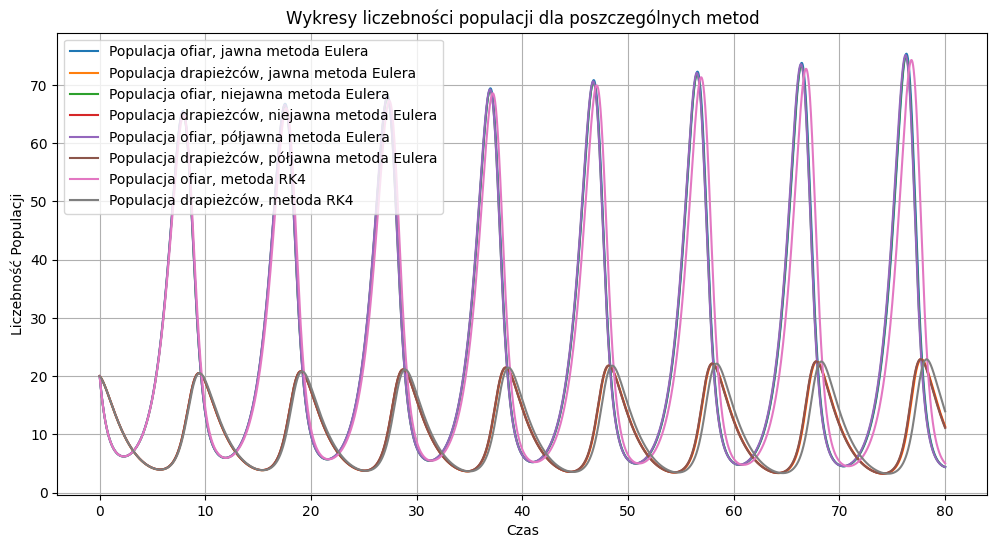

In [113]:
plt.figure(figsize=(12, 6))
plt.title("Wykresy liczebności populacji dla poszczególnych metod")
plot(euler_explicit, "Populacja ofiar, jawna metoda Eulera", "Populacja drapieżców, jawna metoda Eulera")
plot(euler_implicit, "Populacja ofiar, niejawna metoda Eulera", "Populacja drapieżców, niejawna metoda Eulera")
plot(euler_half_explicit, "Populacja ofiar, półjawna metoda Eulera", "Populacja drapieżców, półjawna metoda Eulera")
plot(runge_kutta_4, "Populacja ofiar, metoda RK4", "Populacja drapieżców, metoda RK4")
plt.xlabel('Czas')
plt.ylabel('Liczebność Populacji')
plt.legend()
plt.grid(True)
plt.show()

*Wykres 1. Liczebności populacji dla poszczególnych metod rozwiązywania równań w zależności od czasu*

Widoczne są cykliczne naprzemienne wahania obu populacji. Populacja ofiar dochodzi do wyższych liczebności niż populacja drapieżników. Niewielkie różnice między poszczególnymi liniami wskazują na wpływ wybranej metody numerycznej na dokładność symulacji.

Następnie stworzyliśmy wspólny wykres portretów fazowych układów dla poszczególnych metod.

In [114]:
def plot_phase(function, label, color=None):
    _, x_vec, y_vec, _ = function()
    plt.plot(x_vec, y_vec, label=label, color=color)

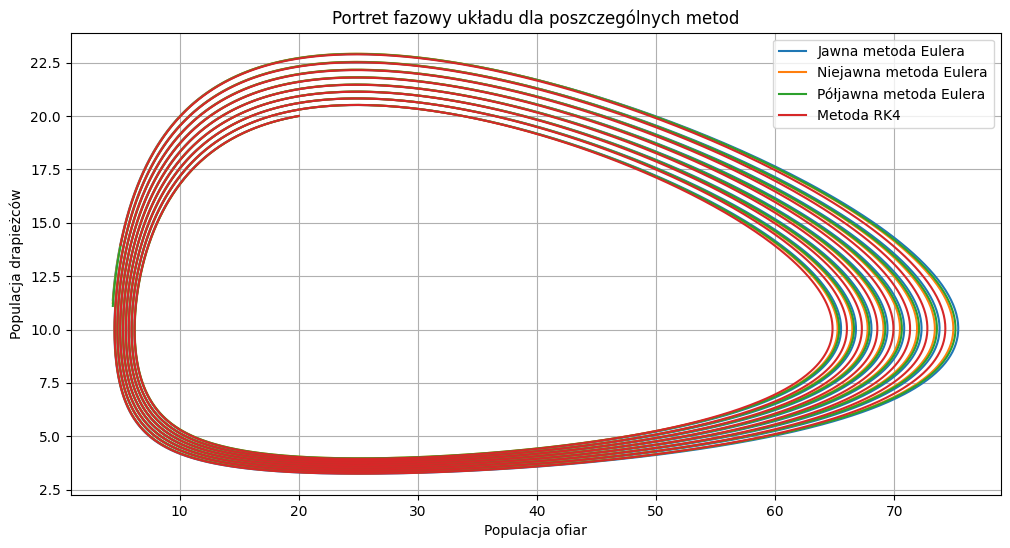

In [115]:
plt.figure(figsize=(12, 6))
plt.title("Portret fazowy układu dla poszczególnych metod")
plot_phase(euler_explicit, "Jawna metoda Eulera")
plot_phase(euler_implicit, "Niejawna metoda Eulera")
plot_phase(euler_half_explicit, "Półjawna metoda Eulera")
plot_phase(runge_kutta_4, "Metoda RK4")
plt.xlabel('Populacja ofiar')
plt.ylabel('Populacja drapieżców')
plt.legend()
plt.grid(True)
plt.show()

*Wykres 2. Portret fazowy układu dla poszczególnych metod rozwiązywania równań*

Widoczne są pętle, co oznacza, że układ jest cykliczny. Fizyczna interpretacja jest taka, że populacje ofiar i drapieżników współistnieją w dynamicznej równowadze: wzrost populacji ofiar prowadzi do wzrostu populacji drapieżników, co z kolei powoduje spadek populacji ofiar, a następnie spadek populacji drapieżników, cykl ten się powtarza. Niewielkie różnice między poszczególnymi liniami wskazują na wpływ wybranej metody numerycznej na dokładność symulacji.

$b)$ 
Następnym naszym zadaniem było wyznaczenie warunktów początkowych liczebności, dla których populacja nie ulegnie zmianie. W tym celu ręcznie rozwiązaliśmy układ równań
$$
x` = x(\alpha_1 - \beta_1 y) = 0
$$
$$
y` = y(-\alpha_2+ \beta_2x) = 0
$$

Układ ten ma cztery przypadki do rozważenia:
1. $x=0$ i $y=0$ - wtedy to układ ma rozwiązanie $(0,0)$
2. $x=0$ i $-\alpha_2+ \beta_2x=0$ - wtedy z racji, że $x=0$ otrzymujemy, że $\alpha_2=0$, co jest sprzeczne z założeniem, że $\alpha_2>0$
3. $-\alpha_1 + \beta_1 y=0$ i $y=0$ - wtedy z racji, że $y=0$ otrzymujemy, że $\alpha_1=0$, co jest sprzeczne z założeniem, że $\alpha_1>0$
4. $-\alpha_1 + \beta_1 y=0$ i $-\alpha_2+ \beta_2x=0$ - wtedy otrzymujemy, że rozwiązaniem układu jest $(\frac{\alpha_2}{\beta_2}, \frac{\alpha_1}{\beta_1})$

Zatem finalnie wynika, że liczebność populacji nie ulegnie zmianie, gdy wartości początkowe będą wynosiły $(0,0)$ lub $(\frac{\alpha_2}{\beta_2}, \frac{\alpha_1}{\beta_1})$.

Podpunkt $c)$ polegał na wyznaczeniu wartości niezmiennika dla poszczególnych metod. Wzór na jego wartość to $$H(x, y) = \beta_2 x + \beta_1 y - \alpha_2 \ln(x) - \alpha_1 \ln(y)$$ Otrzymane wartości nanieśliśmy na poniższy wykres

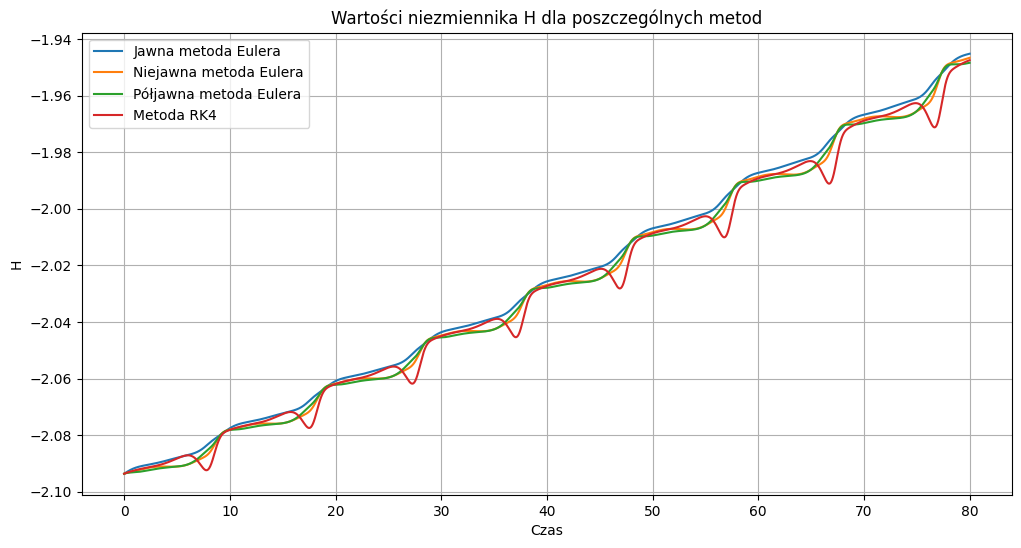

In [116]:
t_vec, _, _, H_euler_explicit = euler_explicit()
H_euler_implicit = euler_implicit()[3]
H_euler_half_explicit = euler_half_explicit()[3]
H_runge_kutta_4 = runge_kutta_4()[3]

plt.figure(figsize=(12, 6))
plt.title("Wartości niezmiennika H dla poszczególnych metod")
plt.plot(t_vec, H_euler_explicit, label="Jawna metoda Eulera")
plt.plot(t_vec, H_euler_implicit, label="Niejawna metoda Eulera")
plt.plot(t_vec, H_euler_half_explicit, label="Półjawna metoda Eulera")
plt.plot(t_vec, H_runge_kutta_4, label="Metoda RK4")
plt.xlabel('Czas')
plt.ylabel('H')
plt.legend()
plt.grid(True)
plt.show()

*Wykres 3. Wartości niezmiennika H dla poszczególnych metod rozwiązywania równań w zależności od czasu*

Dla każdej metody niezmiennik rośnie od wartości około $-2.9$ do około $-1.95$, zatem nie jest zachowany, co może wynikać z niedokładności symulacji.

$d)$ W ostatnim podpunkcie załadowaliśmy dane z załączonego pliku `LynxHare.txt`. Do szacowania współczynników $\theta = [\alpha_1, \alpha_2, \beta_1, \beta_2]$ użyliśmy półjawnej metody Eulera. Zaimplementowaliśmy obie podane funkcje kosztu
$$L_1(\theta) = \sum_{i=0}^{T} ((l_i - \hat{l}_i)^2 + (h_i - \hat{h}_i)^2),$$
$$L_2(\theta) = -\sum_{i=0}^{T} l_i \ln \hat{l}_i - \sum_{i=0}^{T} h_i \ln \hat{h}_i + \sum_{i=0}^{T} \hat{l}_i + \sum_{i=0}^{T} \hat{h}_i.$$
Następnie oszacowaliśmy współczynniki używając funkcji `scipy.optimize.minimize`, z parametrem `method='Nelder-Mead'` i argumantami początkowymi $[\alpha_1, \alpha_2, \beta_1, \beta_2] = [1, 0.5, 0.1, 0.02]$

In [117]:
column_names = ['Year', 'Lynx', 'Hare']

df = pd.read_csv(
    "LynxHare.txt",
    sep='\s+',
    header=None,
    names=column_names
)

year = np.array(df['Year'])
lynx = np.array(df['Lynx'])
hare = np.array(df['Hare'])

In [118]:

nsteps = year[-1] - year[0]
t = np.arange(year[0], year[-1] + 1)
lynx_sim_init = np.zeros(nsteps + 1)
lynx_sim_init[0] = lynx[0]
hare_sim_init = np.zeros(nsteps + 1)
hare_sim_init[0] = hare[0]

def euler_half_implicit_lynx_hare(lynx_sim, hare_sim, a1, b1, a2, b2):
    for k in range(len(t) - 1):
        lynx_sim[k + 1] = lynx_sim[k] / (1 + h * (-a1 + b1 * hare_sim[k]))
        hare_sim[k + 1] = hare_sim[k] + h * hare_sim[k] * (-a2 + b2 * lynx_sim[k])
    return lynx_sim, hare_sim

def L1(theta):
    a1, b1, a2, b2 = theta
    if any(theta < 0):
        return np.inf
    lynx_sim, hare_sim = euler_half_implicit_lynx_hare(
        np.copy(lynx_sim_init), np.copy(hare_sim_init), a1, b1, a2, b2)
    
    rss = np.sum((lynx - lynx_sim)**2) + \
          np.sum((hare - hare_sim)**2)
    return rss

def L2(theta):
    a1, b1, a2, b2 = theta
    if any(theta < 0):
        return np.inf
    lynx_sim, hare_sim = euler_half_implicit_lynx_hare(
        np.copy(lynx_sim_init), np.copy(hare_sim_init), a1, b1, a2, b2)
    
    if any(lynx_sim <= 0) or any(hare_sim <= 0):
        return np.inf
    
    rss = -np.sum(lynx * np.log(lynx_sim)) - \
            np.sum(hare * np.log(hare_sim)) + \
            np.sum(lynx_sim) + np.sum(hare_sim)
    
    return rss

x0 = [1, 0.1, 0.5, 0.02]

In [119]:
result1 = minimize(
    L1,
    x0,
    method='Nelder-Mead',
    options={'disp': True, 'maxiter': 10000, 'fatol': 1e-6}
)
print(result1.x)

Optimization terminated successfully.
         Current function value: 181375.309044
         Iterations: 557
         Function evaluations: 944
[1.11028521e+00 2.12115883e-11 1.21426254e-01 6.07418268e-04]


In [120]:
result2 = minimize(
    L2,
    x0,
    method='Nelder-Mead',
    options={'disp': True, 'maxiter': 10000, 'fatol': 1e-6}
)
print(result2.x)

Optimization terminated successfully.
         Current function value: -17210.102271
         Iterations: 204
         Function evaluations: 358
[1.91437846e+00 2.31813668e-02 3.83753888e-02 1.93203877e-09]


Otrzymaliśmy wyniki $[\alpha_1, \alpha_2, \beta_1, \beta_2] = [1.1103, 2.1212, 1.2143, 6.0742]$ dla $L_1$ i $[\alpha_1, \alpha_2, \beta_1, \beta_2] = [1.9144, 2.3181, 3.8375, 1.9320]$ dla $L_2$. Wyniki różnią się, lecz wartości są tego samego rzędu wielkości.

## Bibliografia

 - Materiały zamieszczone na platformie Microsoft Teams w zespole $\textit{MOwNiT 2025}$ w zakładce $\textit{Materiały z zajęć/lab09/lab9-intro.pdf}$